
# Environment configuration

In [1]:
!pip install pytorch-lightning
!pip install umap-learn
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 83.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl s

In [2]:
!databricks configure --host https://community.cloud.databricks.com/

Username: romanowskarolina@gmail.com
Password: 
Repeat for confirmation: 


In [38]:
experiment_run = True
run_name = input("Enter run name: ")
if not experiment_name:
  experiment_run = False

Enter experiment name: Test run


In [39]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision
import torchvision.transforms as transforms
import copy
from pytorch_lightning.loggers import MLFlowLogger
import umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [40]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Hardware accelerator:", device)
torch.cuda.empty_cache()

Hardware accelerator: cuda:0


## Constants

In [41]:
train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


batch_size = 128
num_workers = 2
num_classes = 10
max_epochs=20
learning_rate = 0.001
classes_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

## Data preparation

In [42]:
train_data = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
train_size = int(0.8*len(train_data))
train_set, validation_set = torch.utils.data.random_split(train_data, [train_size, len(train_data) - train_size])
test_data = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [43]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

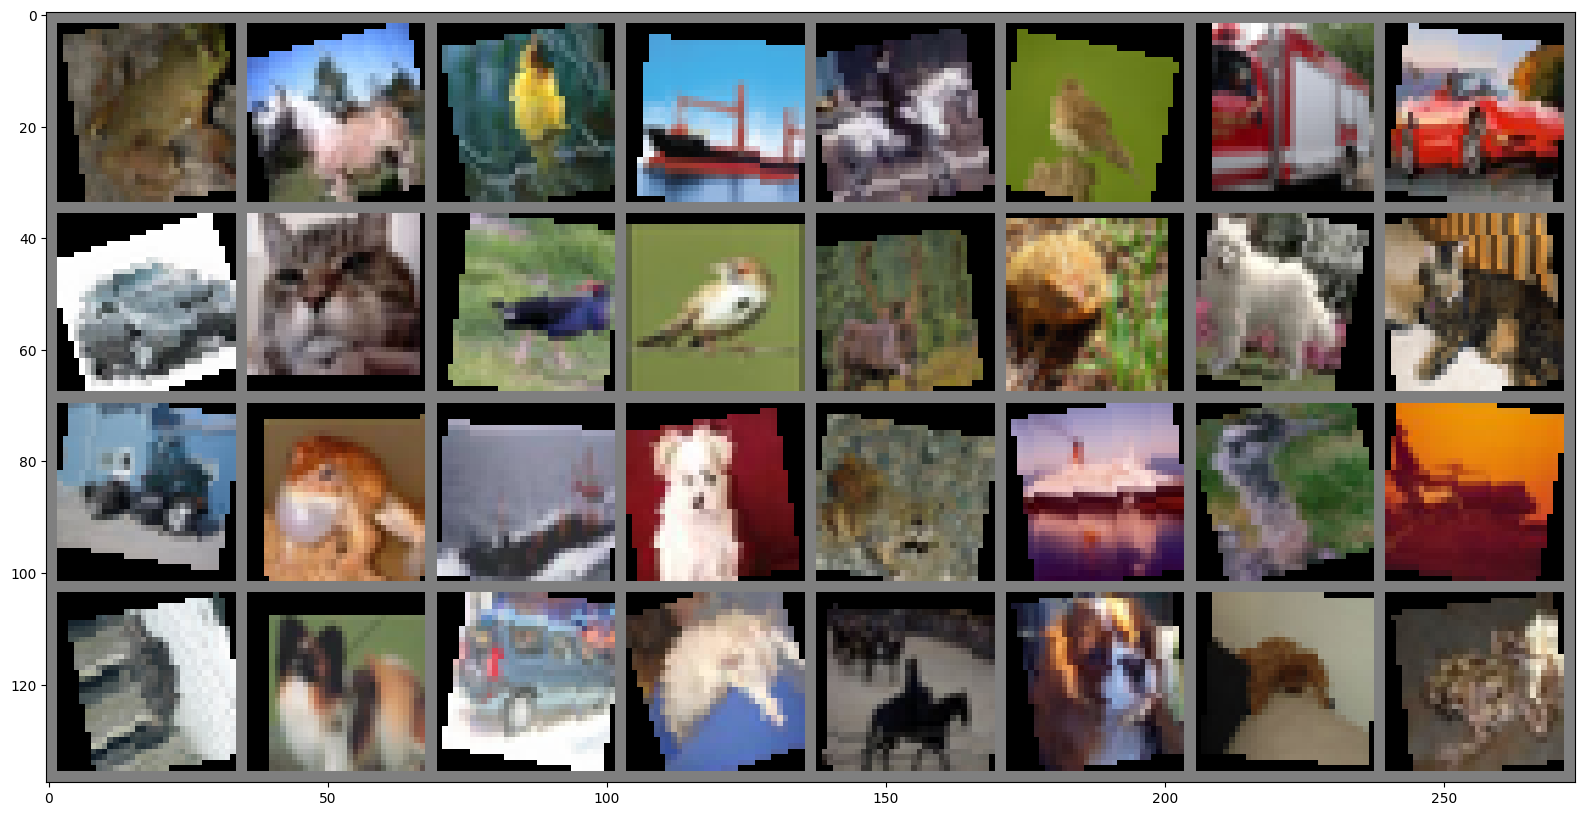

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
plt.figure(figsize = (20,10))

def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))

# Neural Network Architecture

In [45]:
class CrossEntropyLoss:
  def __call__(self, x, y):
    return nn.functional.cross_entropy(x, y)
  
  def __str__(self):
    return "CrossEntropyLoss"

In [46]:
class Baseline(nn.Module):
    def __init__(self, num_classes):
      super().__init__()
      self.layer1 = nn.Sequential(
          nn.Conv2d(3, 6, kernel_size=5),
          nn.Tanh(),
          nn.AvgPool2d(kernel_size=2, stride=2))
      self.layer2 = nn.Sequential(
          nn.Conv2d(6, 16, kernel_size=5),
          nn.Tanh(),
          nn.AvgPool2d(kernel_size = 2, stride = 2))
      self.layer3 = nn.Sequential(
          nn.Conv2d(16, 120, kernel_size=5),
          nn.Tanh())
      self.layer4 = nn.Sequential(
          nn.Linear(120, 84),
          nn.Tanh()
      )
      self.layer5 = nn.Sequential(
          nn.Linear(84, num_classes),
          nn.Softmax(dim=1)
      )
    
    def __str__(self):
      # https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/
      return "Baseline: Lenet-5"
        
    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = torch.flatten(x, 1)
      x = self.layer4(x)
      x = self.layer5(x)
      return x

In [47]:
class LitClassificator(pl.LightningModule):
    def __init__(self, model, num_classes, learning_rate=0.1):
        super().__init__()
        self.classifier = model
        self.loss_fun = CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.classifier(x)
        loss = self.loss_fun(z, y)
        acc = self.train_acc(z, y)
        logs = {"train_loss": loss, "train_acc": acc}
        self.logger.log_metrics(logs, step=self.trainer.max_steps)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        z = self.classifier(x)
        loss = self.loss_fun(z, y)
        acc = self.val_acc(z, y)
        logs = {"val_loss": loss, "val_acc": acc}
        self.logger.log_metrics(logs, step=self.trainer.max_steps)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.classifier(x)
        acc = self.test_acc(z, y)
        logs = {"test_acc": acc}
        self.logger.log_metrics(logs, step=self.trainer.max_steps)
        

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def on_fit_start(self):
        self.logger.log_hyperparams({"learning rate": self.learning_rate, "loss function": self.loss_fun.__str__(), "model": self.classifier.__str__()})
    

## Training loop

In [49]:
model = Baseline(num_classes)
lit_classificator = LitClassificator(model, num_classes)
mlf_logger = MLFlowLogger(experiment_name="/Users/romanowskarolina@gmail.com/DreamingCL", tracking_uri="databricks", run_name=run_name)

trainer = pl.Trainer(logger=mlf_logger if experiment_run else None, max_epochs=max_epochs)
tuner = pl.tuner.Tuner(trainer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [50]:
# lr_finder = tuner.lr_find(lit_classificator, train_dataloaders=train_loader)
# print(lr_finder.results)
# fig = lr_finder.plot(suggest=True)
# fig.show()

# lit_classificator.learning_rate = lr_finder.suggestion()
lit_classificator.learning_rate  = learning_rate

In [51]:
trainer.fit(lit_classificator, train_dataloaders=train_loader, val_dataloaders=validation_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params
--------------------------------------------------
0 | classifier | Baseline           | 62.0 K
1 | train_acc  | MulticlassAccuracy | 0     
2 | val_acc    | MulticlassAccuracy | 0     
3 | test_acc   | MulticlassAccuracy | 0     
--------------------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## Test loop

In [52]:
trainer.test(lit_classificator, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{}]

In [53]:
model_path = f"state_dict_model_{mlf_logger.run_id}.pt"
torch.save(model.state_dict(), model_path)
mlf_logger.experiment.log_artifact(mlf_logger.run_id, model_path)

In [54]:
# %load_ext tensorboard
# %tensorboard --logdir .

In [55]:
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial10/Adversarial_Attacks.html
def show_prediction(img, label, pred, K=5, noise=None):
    label = label.item()
    img = img.cpu().permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5
    if noise is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 4, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
  
    ax[0].imshow(img)
    ax[0].set_title(classes_names[label])
    ax[0].axis('off')

    if noise is not None:
      # Visualize noise
      noise = noise.cpu().permute(1, 2, 0).numpy()
      noise = noise * 0.5 + 0.5 # Scale between 0 to 1
      ax[1].imshow(noise)
      ax[1].set_title('starting point')
      ax[1].axis('off')
      ax[2].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([classes_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

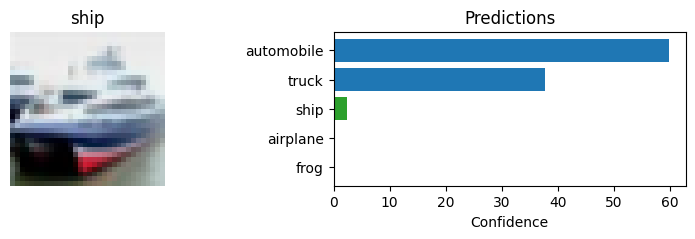

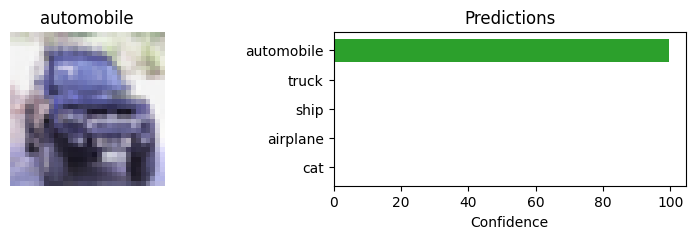

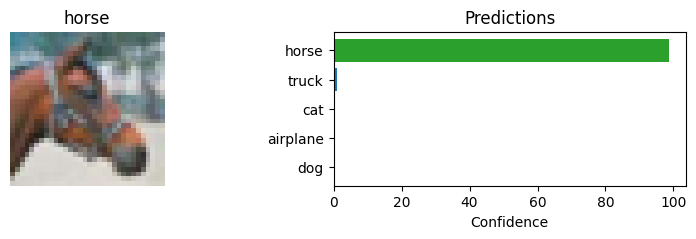

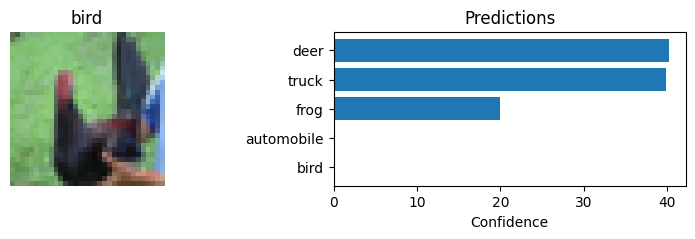

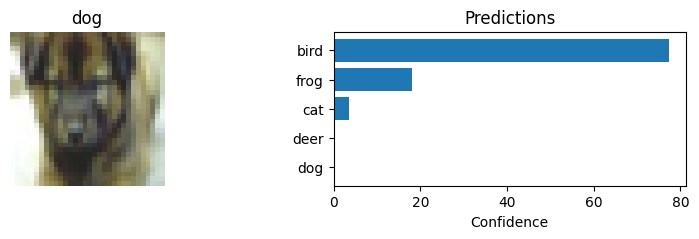

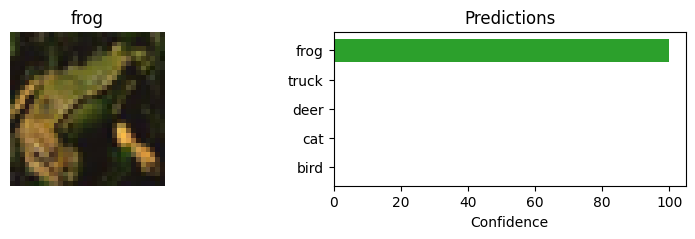

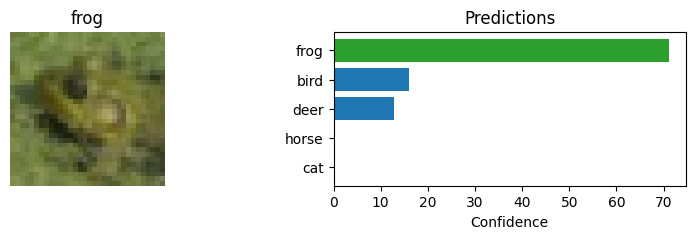

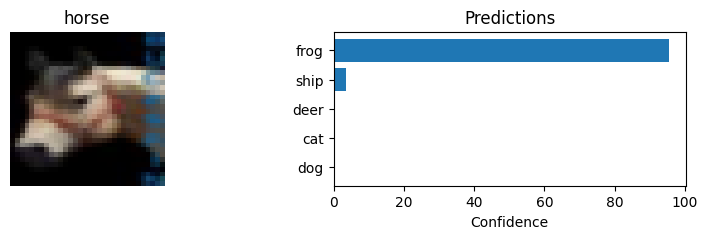

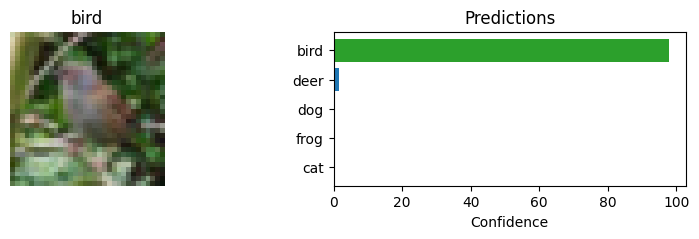

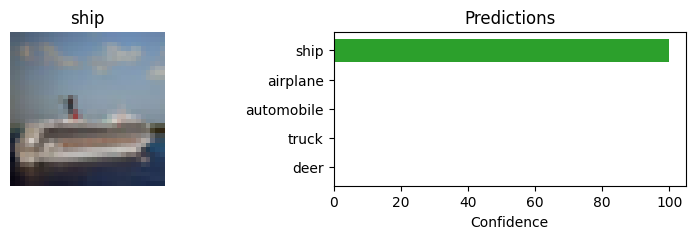

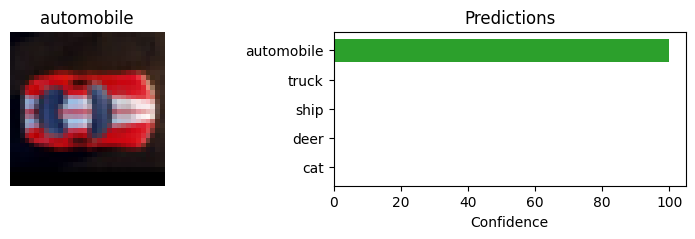

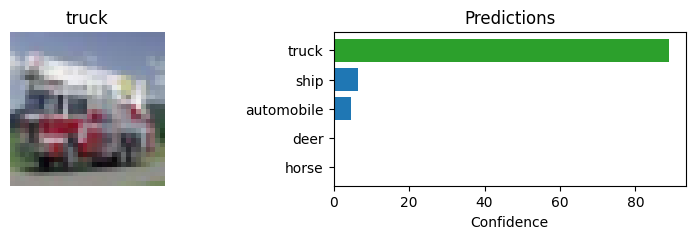

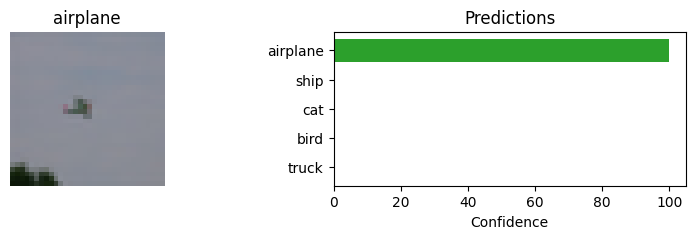

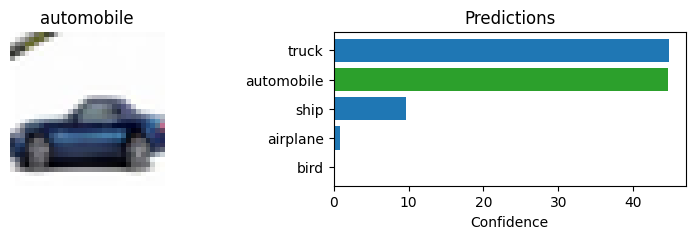

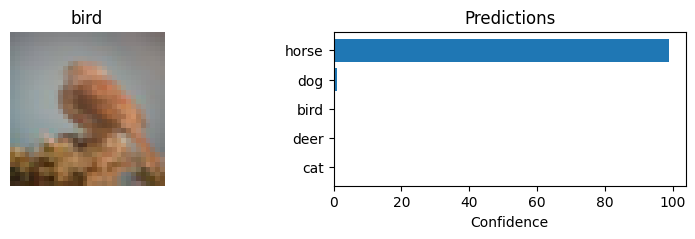

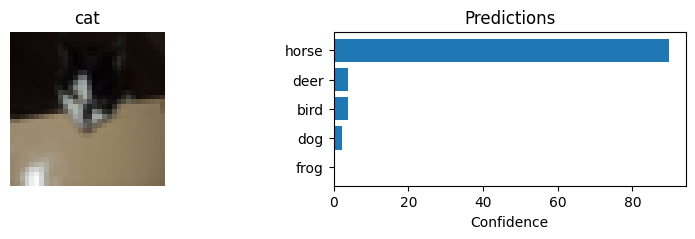

In [56]:
batch, labels = next(iter(test_loader))
with torch.no_grad():
    preds = lit_classificator.classifier(batch)
for i in range(1, 128, 8):
    show_prediction(batch[i], labels[i], preds[i])

In [58]:
umap = umap.UMAP(metric="cosine", n_neighbors=100)

In [59]:
def embed_imgs(model, data_loader):
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
          z = model.classifier(imgs)
        img_list.append(imgs)
        embed_list.append(z)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))

In [60]:
train_img_embeds = embed_imgs(lit_classificator, train_loader)
test_img_embeds = embed_imgs(lit_classificator, test_loader)

In [61]:
sample_size = 5000
example_size = 10

In [62]:
train_embedded = umap.fit_transform(train_img_embeds[1][:sample_size].cpu())
data = pd.DataFrame(train_embedded)
data["label"] = train_img_embeds[2][:sample_size].cpu().numpy()

In [63]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)

In [103]:
examples = []
examples_locations = []
for i in np.random.randint(0, sample_size, example_size):
    examples.append(train_img_embeds[0][i].cpu().numpy())
    examples_locations.append(data.iloc[i])

In [65]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.1
)
for location, example in zip(examples_locations, examples):
    x, y = location[0], location[1]
    label = int(location["label"])
    ab = AnnotationBbox(OffsetImage(np.swapaxes(np.swapaxes(example,0,1),1,2)/2+0.5, zoom=1), (x, y), frameon=True,
                        bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
    ax.add_artist(ab)
plt.show()

# Memory Recovery Paradigmat

## Architecture

In [97]:
class MemoryRecoveryParadigmat:
  def __init__(self, model, classes_names, logger=None, debug=False, learning_rate=0.01, num_epochs=200000):
    self.model = model
    self.num_epochs = 200000
    self.debug = debug
    self.logger = logger
    self.classes_names = classes_names
    self.learning_rate = learning_rate
    self.history = []
    self.loss_fun = lambda output, label: -output[0][label]
  
  def generate_noise(self):
    return torch.nn.parameter.Parameter(torch.empty(3,32,32, dtype=torch.float32).uniform_(0,1))

  def get_image(self, class_name):
    input = self.generate_noise()
    optimizer = torch.optim.Adam(params=[input], lr=self.learning_rate)
    image_class = torch.LongTensor([classes_names.index(class_name)])
    print(image_class)
    for epoch in range(self.num_epochs):
        preds = self.model.classifier(input.unsqueeze(0))
        optimizer.zero_grad()
        loss = self.loss_fun(preds, image_class)
        loss.backward()
        optimizer.step()
        if epoch % 10000 == 0:
          _, predictions = torch.max(preds, 1)
          if self.debug:
            print(f'epoch: {epoch}/{self.num_epochs}, activation: {loss.item()}, preds: {predictions}')
            img = self.prepare_image(input)
            plt.figure()
            plt.imshow(img.astype(np.uint8))
          
          self.history.append(loss.item())
          if predictions.item() == image_class.item() and len(self.history) > 5 and all(h_loss == self.history[-1] for h_loss in self.history[-5:]): # early stopping
            break
          
    img = self.prepare_image(input)
    self.log(img, class_name)
    return img, preds, image_class.item()
  
  def log(self, img, class_name):
    if self.logger is not None:
      fig = plt.figure()
      plt.imshow(img)
      self.logger.log_figure(mlf_logger.run_id, fig, f"{class_name}.png")

  def prepare_image(self, input):
    a = input.detach().numpy().squeeze().transpose([1,2,0])
    b = a - np.min(a)
    b = 255 * b / np.max(b)
    return b.astype(np.uint8)

In [98]:
class MRP_ZS_IL(MemoryRecoveryParadigmat):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.loss = torch.nn.BCELoss()
    self.cwh = [3,32,32]

  def generate_noise(self):
    inputs = torch.randn((self.cwh[0], self.cwh[1], self.cwh[2]))
    inputs = torch.autograd.Variable(inputs ,requires_grad=True)
    return inputs

## Run

In [99]:
lit_classificator.classifier.eval()
syntethized_data = []
mrp = MemoryRecoveryParadigmat(lit_classificator, classes_names, logger = mlf_logger.experiment if experiment_run else None, debug=True)

In [100]:
experiment_run = False

In [104]:
mrp = MRP_ZS_IL(lit_classificator, classes_names, logger = mlf_logger.experiment if experiment_run else None, debug=True)

tensor([5])
epoch: 0/200000, activation: -0.001530953450128436, preds: tensor([8])
epoch: 10000/200000, activation: -0.9999967813491821, preds: tensor([5])
epoch: 20000/200000, activation: -0.9999995231628418, preds: tensor([5])
epoch: 30000/200000, activation: -0.9999996423721313, preds: tensor([5])
epoch: 40000/200000, activation: -0.9999996423721313, preds: tensor([5])
epoch: 50000/200000, activation: -0.9999996423721313, preds: tensor([5])
epoch: 60000/200000, activation: -0.9999996423721313, preds: tensor([5])
epoch: 70000/200000, activation: -0.9999996423721313, preds: tensor([5])


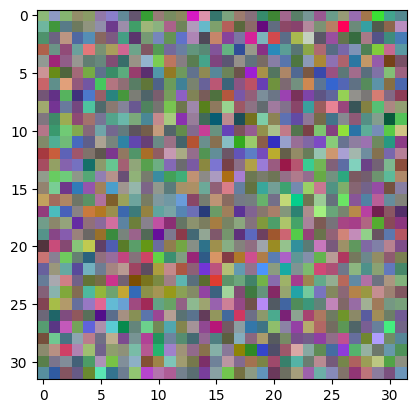

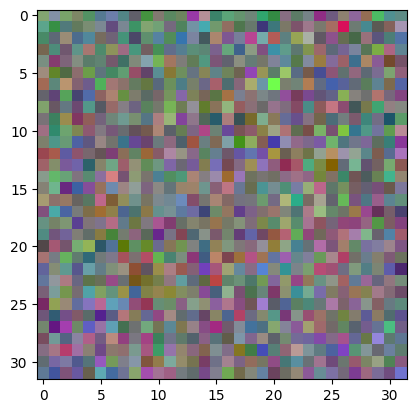

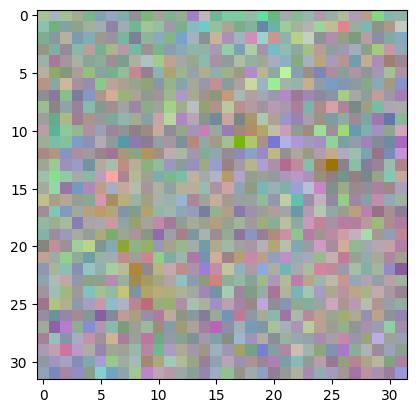

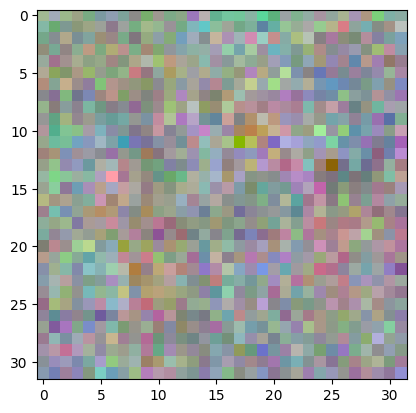

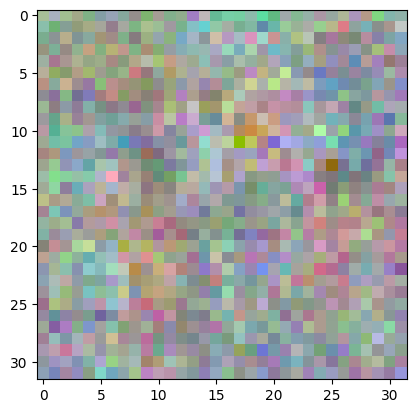

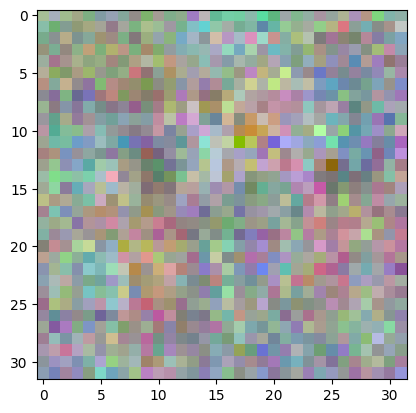

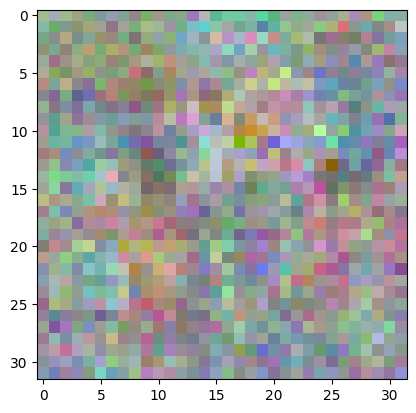

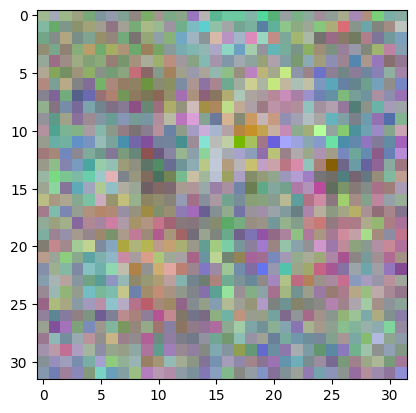

In [105]:
syntethized_data.append(mrp.get_image("dog"))

tensor([1])
epoch: 0/200000, activation: -0.1687573492527008, preds: tensor([9])
epoch: 10000/200000, activation: -1.0, preds: tensor([1])
epoch: 20000/200000, activation: -1.0, preds: tensor([1])
epoch: 30000/200000, activation: -1.0, preds: tensor([1])
epoch: 40000/200000, activation: -1.0, preds: tensor([1])
epoch: 50000/200000, activation: -1.0, preds: tensor([1])


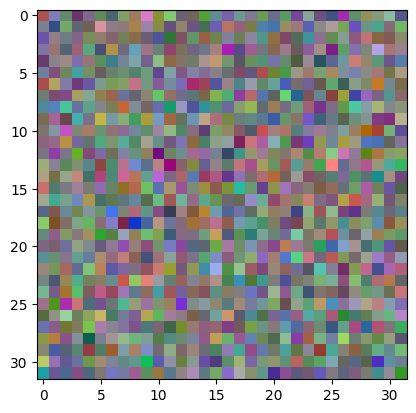

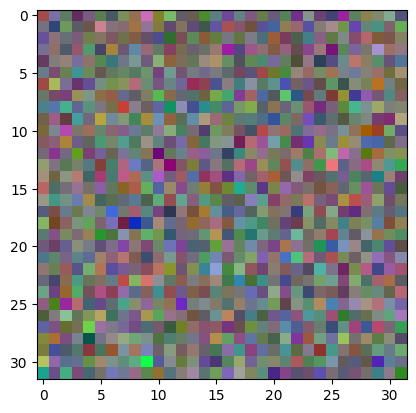

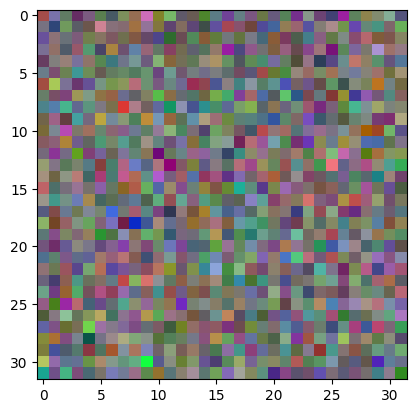

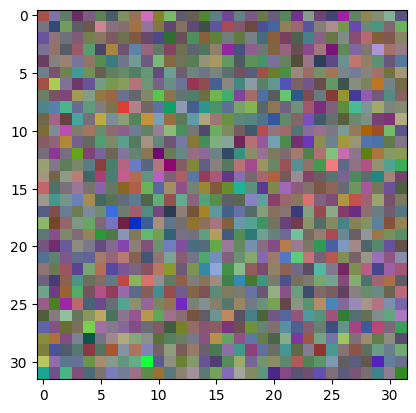

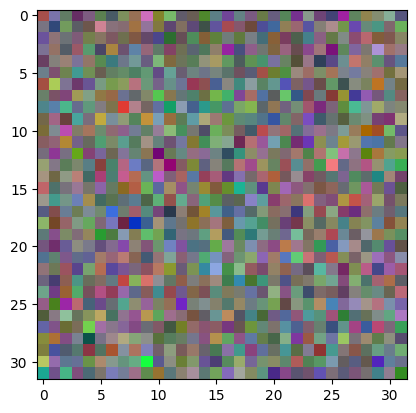

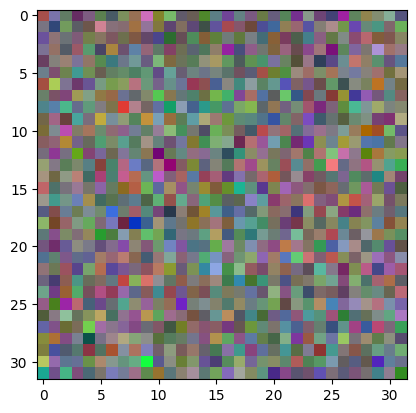

In [106]:
syntethized_data.append(mrp.get_image("automobile"))

tensor([0])
epoch: 0/200000, activation: -0.025641100481152534, preds: tensor([9])
epoch: 10000/200000, activation: -1.0, preds: tensor([0])
epoch: 20000/200000, activation: -1.0, preds: tensor([0])
epoch: 30000/200000, activation: -1.0, preds: tensor([0])
epoch: 40000/200000, activation: -1.0, preds: tensor([0])
epoch: 50000/200000, activation: -1.0, preds: tensor([0])


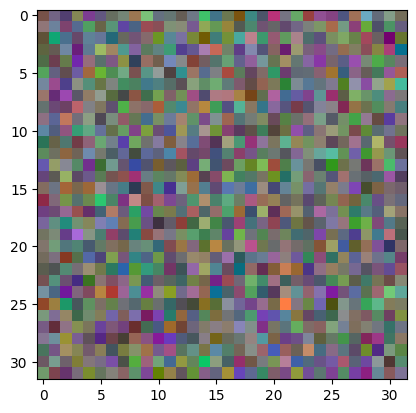

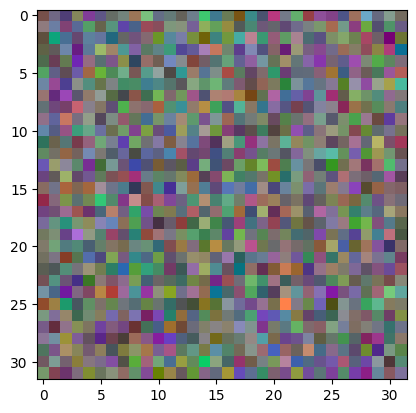

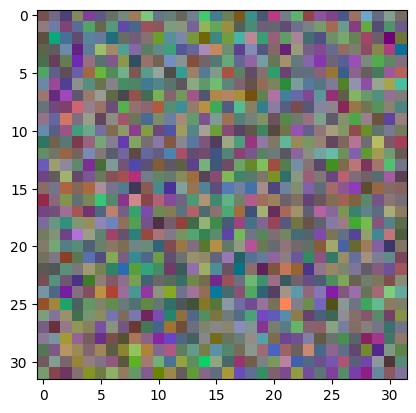

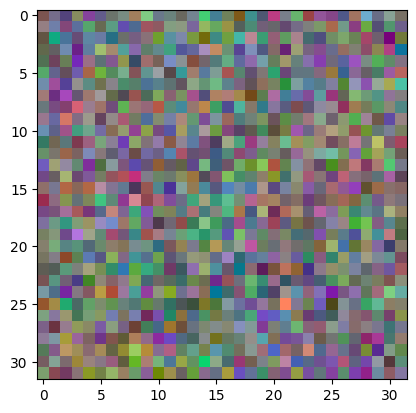

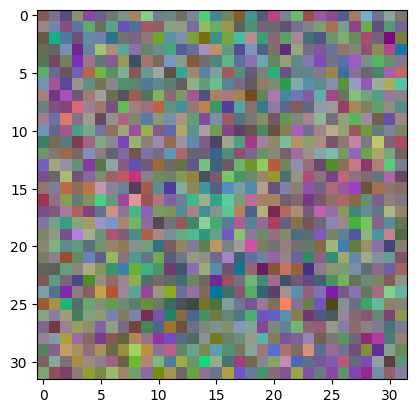

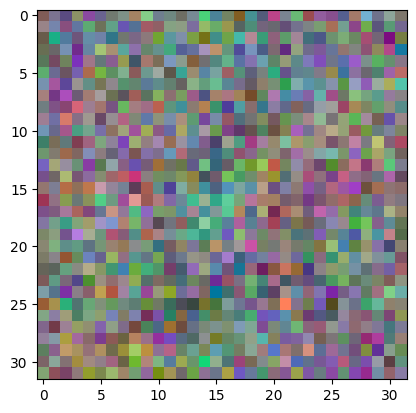

In [107]:
syntethized_data.append(mrp.get_image("airplane"))

tensor([4])
epoch: 0/200000, activation: -0.0007702753064222634, preds: tensor([1])
epoch: 10000/200000, activation: -0.9999947547912598, preds: tensor([4])
epoch: 20000/200000, activation: -0.9999988079071045, preds: tensor([4])
epoch: 30000/200000, activation: -0.9999990463256836, preds: tensor([4])
epoch: 40000/200000, activation: -0.9999991655349731, preds: tensor([4])
epoch: 50000/200000, activation: -0.9999991655349731, preds: tensor([4])
epoch: 60000/200000, activation: -0.9999991655349731, preds: tensor([4])
epoch: 70000/200000, activation: -0.9999991655349731, preds: tensor([4])
epoch: 80000/200000, activation: -0.9999991655349731, preds: tensor([4])


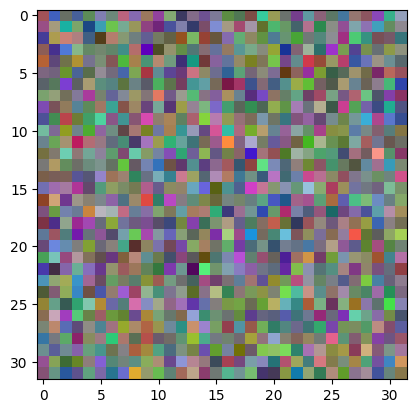

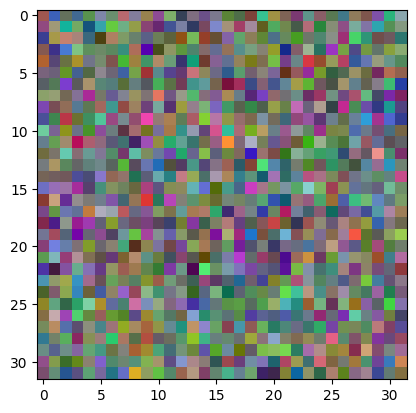

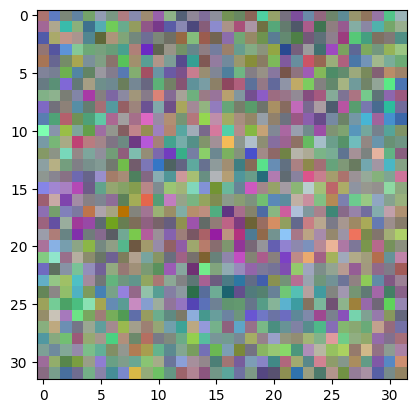

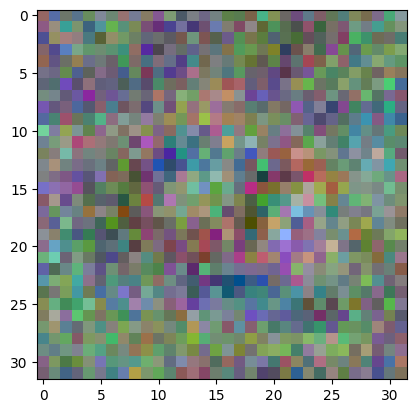

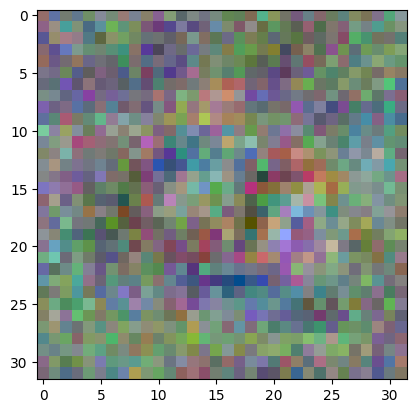

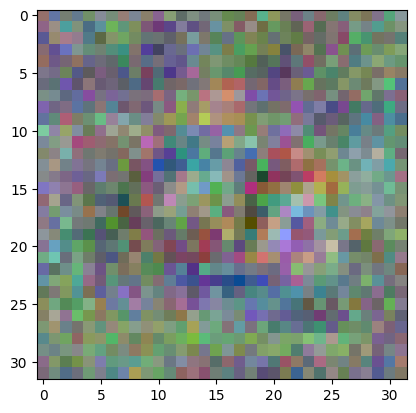

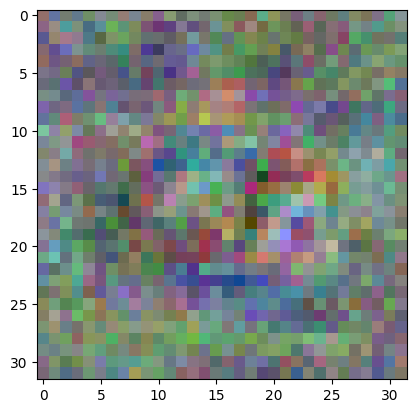

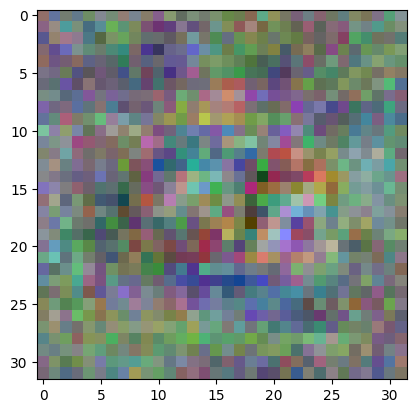

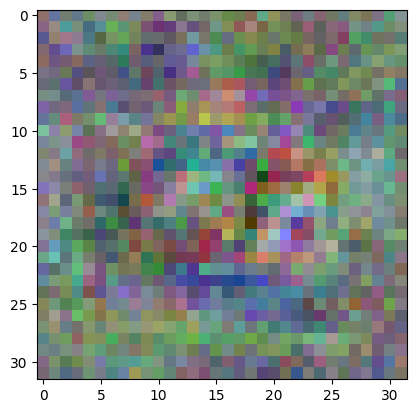

In [108]:
syntethized_data.append(mrp.get_image("deer"))

tensor([6])
epoch: 0/200000, activation: -0.011653626337647438, preds: tensor([9])
epoch: 10000/200000, activation: -0.9999938011169434, preds: tensor([6])
epoch: 20000/200000, activation: -0.9999991655349731, preds: tensor([6])
epoch: 30000/200000, activation: -0.9999996423721313, preds: tensor([6])
epoch: 40000/200000, activation: -0.9999996423721313, preds: tensor([6])
epoch: 50000/200000, activation: -0.9999996423721313, preds: tensor([6])
epoch: 60000/200000, activation: -0.9999996423721313, preds: tensor([6])
epoch: 70000/200000, activation: -0.9999996423721313, preds: tensor([6])


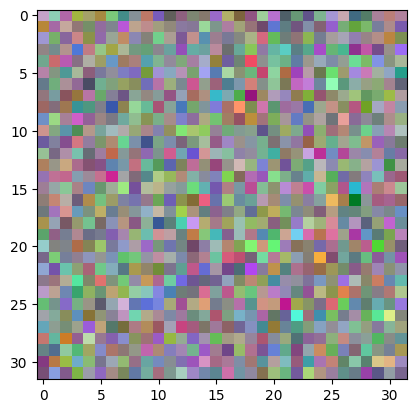

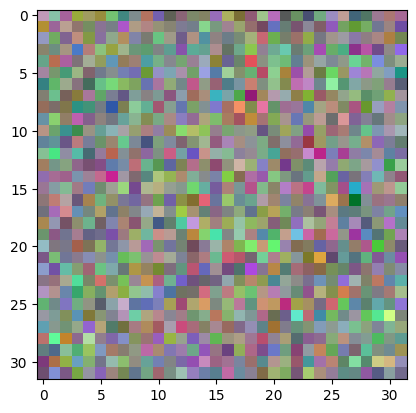

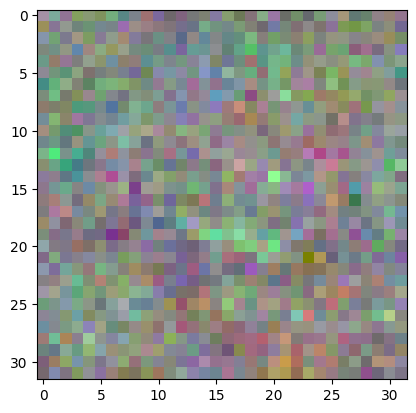

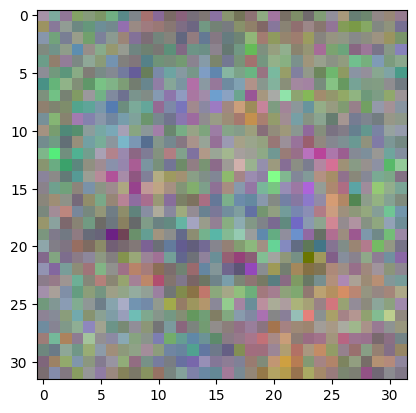

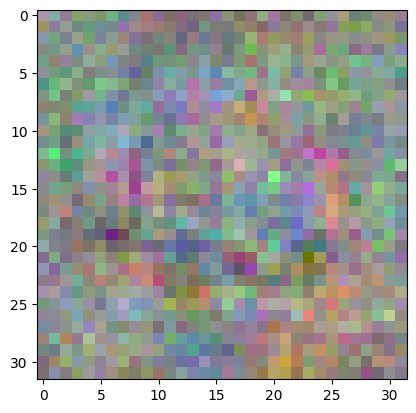

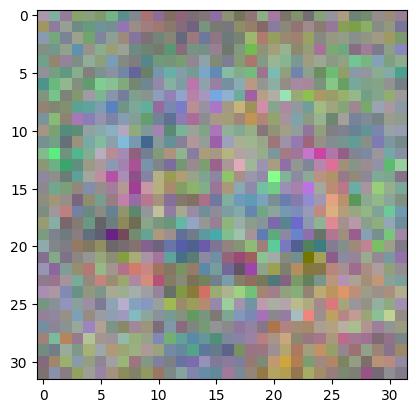

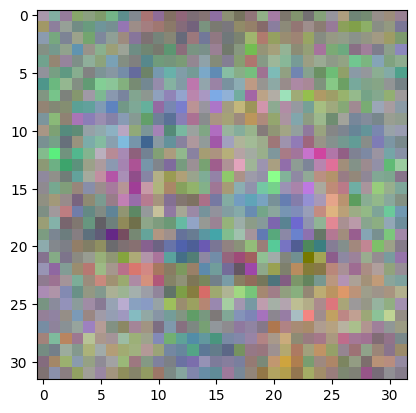

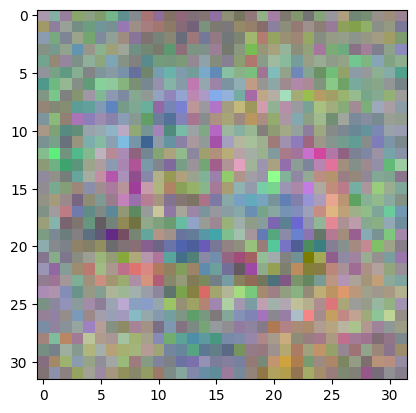

In [109]:
syntethized_data.append(mrp.get_image("frog"))

## Visualization

In [110]:
t_train_img_embedes = torch.cat((train_img_embeds[1][:sample_size].cpu(), torch.FloatTensor([d[1].squeeze(0).detach().numpy() for d in syntethized_data])), 0)
train_embedded = umap.fit_transform(t_train_img_embedes)
data = pd.DataFrame(train_embedded)
data["label"] = np.concatenate((train_img_embeds[2][:sample_size].cpu().numpy(), np.array([d[2] for d in syntethized_data])))
examples = []
examples_locations = []
for i in np.random.randint(0, sample_size, example_size):
    img = train_img_embeds[0][i].cpu().numpy()
    img = np.swapaxes(np.swapaxes(img,0,1),1,2)/2+0.5
    examples.append(img)
    examples_locations.append(data.iloc[i])
examples += [d[0] for d in syntethized_data]
examples_locations += [data.iloc[i] for i in range(len(data)-len(syntethized_data), len(data))]

<Axes: xlabel='0', ylabel='1'>

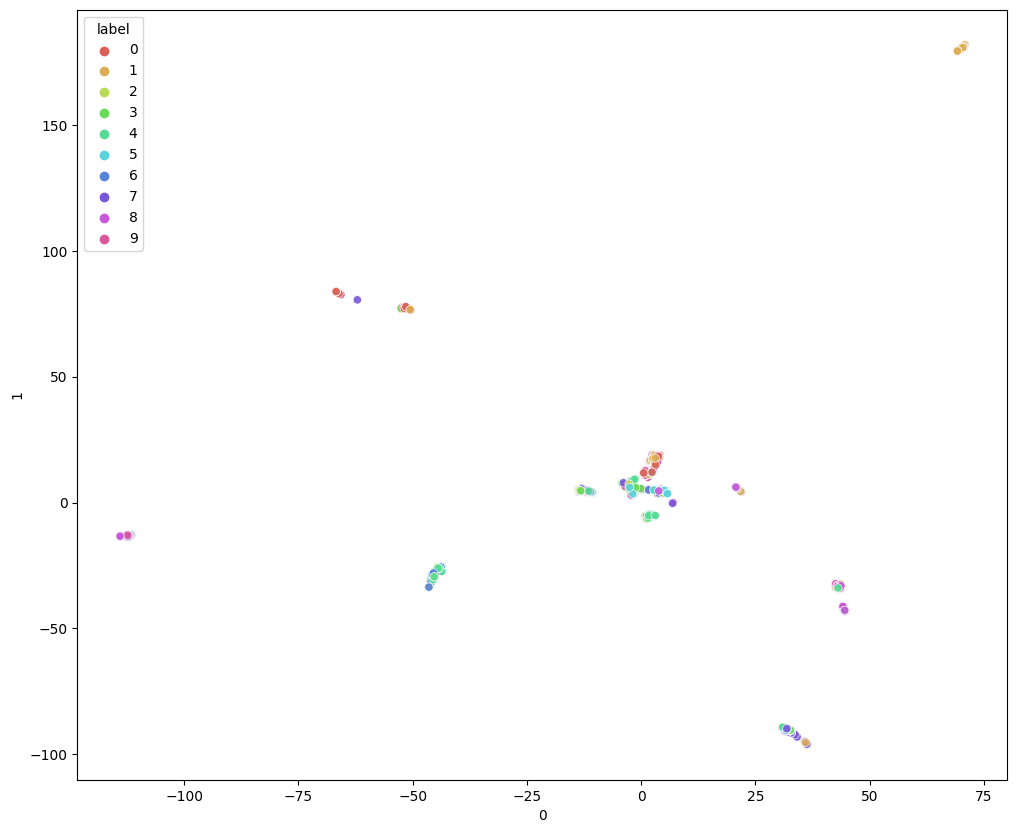

In [111]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)

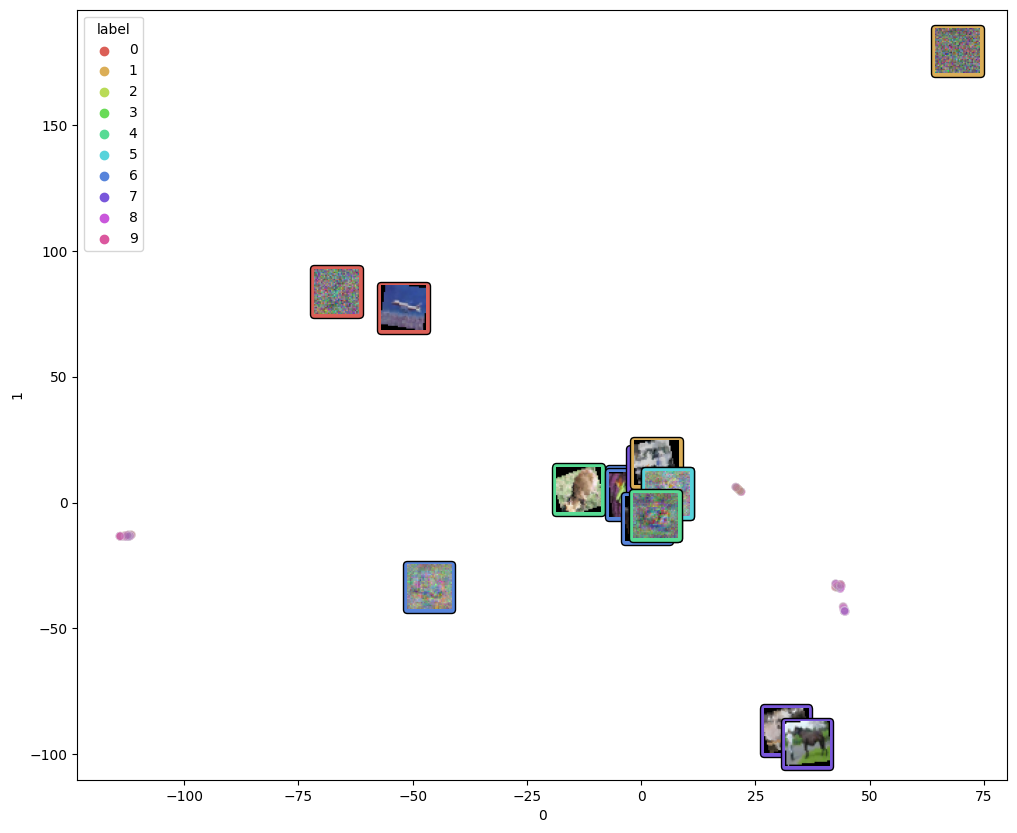

In [112]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.1
)

for location, example in zip(examples_locations, examples):
    x, y = location[0], location[1]
    label = int(location["label"])
    ab = AnnotationBbox(OffsetImage(example, zoom=1), (x, y), frameon=True,
                        bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
    ax.add_artist(ab)
plt.show()

In [113]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from sklearn import neighbors

# points = np.array([[data.iloc[i,0], data.iloc[i,1]] for i in range(i, len(data))]).reshape(-1, 2)
# groups = [data.iloc[i, 2] for i in range(i, len(data))]

# fig, ax = plt.subplots(ncols=1, figsize=(7, 5), sharey=True, sharex=True)


# ax.scatter(points[:, 0], points[:, 1], c=groups)

# clf = neighbors.KNeighborsClassifier(10)
# clf.fit(points, groups)

# x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
# y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
# xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
#                      np.linspace(y_min, y_max, 50))
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
# ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], alpha=0.3, aspect='auto', origin='lower')
# plt.show()
